In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import re

from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score

# Preparing data

## Read the Data

In [2]:
df1 = pd.read_csv("data/train_data.csv")

## Number of Transactions

In [3]:
print("Number of rows = " + str(len(df1.index)))
print("Number of fradulent transactions = " + str(len(df1.loc[df1['label'] == 1])))
print("Number of valid transactions = " + str(len(df1.loc[df1['label'] == 0])))

Number of rows = 189628
Number of fradulent transactions = 276
Number of valid transactions = 189352


## Sample Data

In [4]:
df1.head()

,Id,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,accountcode,mail_id,ip_id,card_id,label
0,1,GB,mccredit,546097.0,4500.0,GBP,GB,Ecommerce,True,1,UKAccount,email132571,ip123779,card250169,0
1,2,GB,mcdebit,557349.0,3395.0,GBP,GB,Ecommerce,True,1,UKAccount,email312302,ip298387,card14235,0
2,3,GB,mccredit,542011.0,3895.0,GBP,GB,Ecommerce,True,1,UKAccount,email255027,ip260053,card31944,0
3,4,GB,visadebit,465943.0,15345.0,GBP,GB,ContAuth,False,0,UKAccount,email283167,ip54851,card120871,0
4,6,GB,visadebit,475127.0,5095.0,GBP,GB,Ecommerce,True,1,UKAccount,email325263,ip203929,card208017,0


## Data Preprocessing

In [5]:
#Prepare card id and ip id for plotting

# 1.Card ID
card_enc = LabelEncoder()
card_enc.fit(df1['card_id'])
df1['card_id'] = card_enc.transform(df1.card_id)

# 2.IP ID
ip_enc = LabelEncoder()
ip_enc.fit(df1['ip_id'])
df1['ip_id'] = ip_enc.transform(df1.ip_id)


## Fradulent transactions per card id

In [6]:
df2 = df1[['card_id','label']].groupby(['card_id']).sum().sort_values(['label'], ascending=False)

print(f"Cards with frauds committed: {len(df2.loc[df2['label'] > 0])}")

df2.head()

Cards with frauds committed: 252


,label
card_id,
157140,4
41564,4
99562,3
128466,3
74739,2


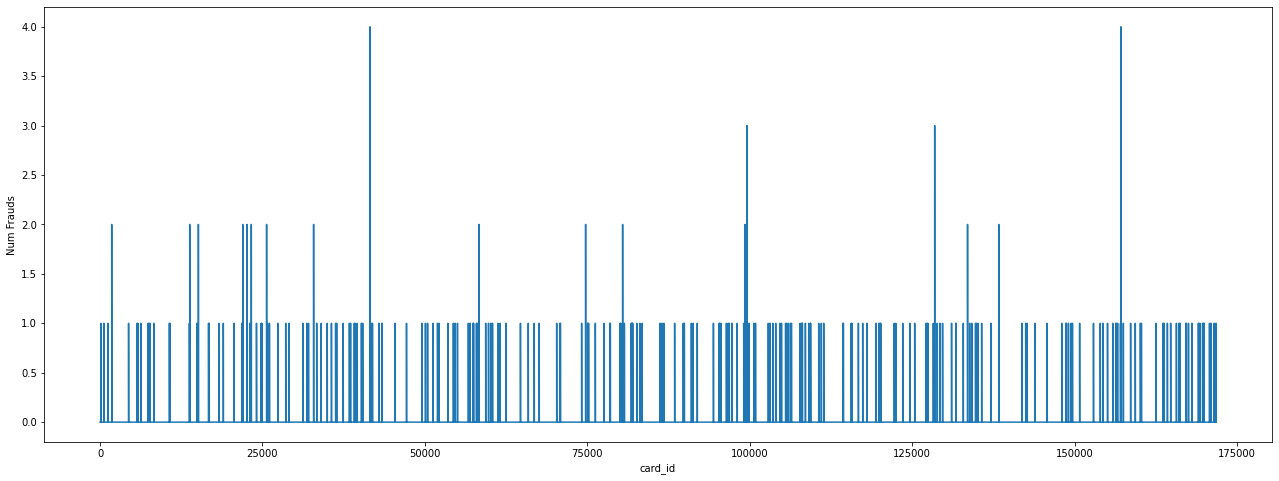

In [7]:
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df2.index,y=df2['label'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Fradulent transactions per IP

In [8]:
df3 = df1[['ip_id','label']].groupby(['ip_id']).sum().sort_values(['label'], ascending=False)

print(f"IPs with frauds committed: {len(df3.loc[df3['label'] > 0])}")

df3.head()

IPs with frauds committed: 251


,label
ip_id,
154455,5
150269,4
26491,3
152650,3
12537,3


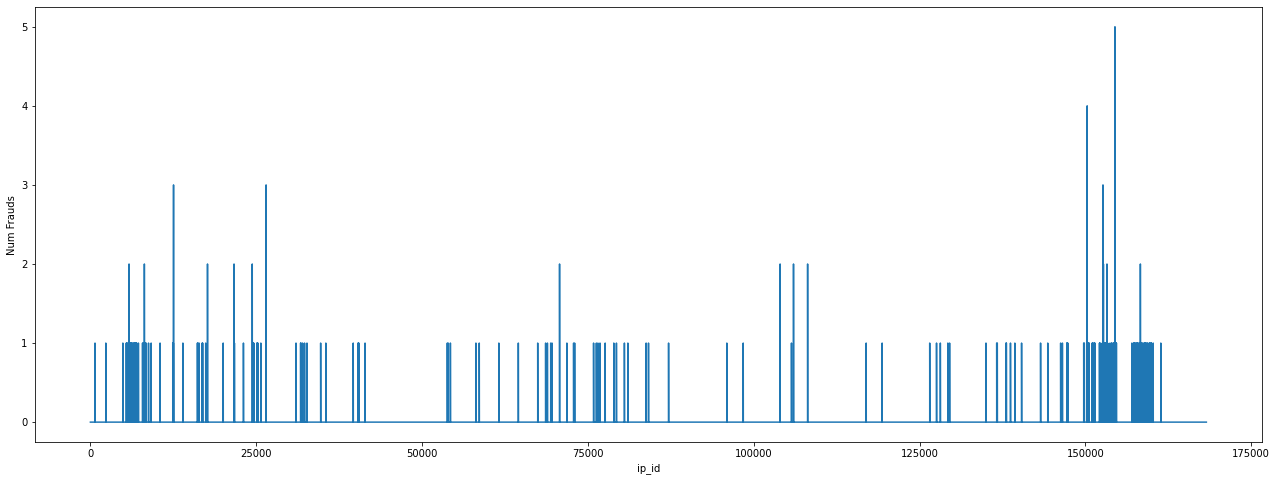

In [9]:
f, (ax) = plt.subplots(1,figsize =(22, 8))
ax = sns.lineplot(x=df3.index,y=df3['label'])
ax.set(ylabel = "Num Frauds")
plt.show()

## Data Preprocessing

In [10]:
def currency_to_eur(row):
    currency_dict = {"BGN": 1.9558, "NZD": 1.6805, "ILS": 4.0448, "RUB": 72.2099, "CAD": 1.5075, "USD": 1.1218,
                     "PHP": 58.125, "CHF": 1.1437, "ZAR": 16.0224, "AUD": 1.5911, "JPY": 124.93, "TRY": 6.6913,
                     "HKD": 8.8007, "MYR": 4.6314, "THB": 35.802, "HRK": 7.413, "NOK": 9.6678, "IDR": 15953.68,
                     "DKK": 7.4646, "CZK": 25.659, "HUF": 322.97, "GBP": 0.86248, "MXN": 21.2829, "KRW": 1308.01,
                     "ISK": 136.2, "SGD": 1.5263, "BRL": 4.405, "PLN": 4.2868, "INR": 78.0615, "RON": 4.7596,
                     "CNY": 7.5541, "SEK": 10.635}
    return row['amount'] / (currency_dict[row['currencycode']] * 100)

def process_data(df):
    # Prepare card id and ip id for plotting
    
    # 1.Card ID
    card_enc = LabelEncoder()
    card_enc.fit(df['card_id'])
    df['card_id'] = card_enc.transform(df.card_id)

    # 2.IP ID
    ip_enc = LabelEncoder()
    ip_enc.fit(df['ip_id'])
    df['ip_id'] = ip_enc.transform(df.ip_id)

    #Encoding, Cleaning the data
    df.loc[df['cardverificationcodesupplied'].isna(), 'cardverificationcodesupplied'] = False
    df.loc[df['issuercountrycode'].isna(), 'issuercountrycode'] = 'ZZ'
    df.loc[df['shoppercountrycode'].isna(), 'shoppercountrycode'] = 'ZZ'

    unique_issuer_cc = df['issuercountrycode'].unique()
    unique_shopper_cc = df['shoppercountrycode'].unique()
    both = np.append(unique_issuer_cc, unique_shopper_cc)
    df_countrycodes = pd.DataFrame(both)
    unique_codes = df_countrycodes[0].unique()
    enc = LabelEncoder()
    enc.fit(unique_codes)
    df['issuercountrycode'] = enc.transform(df.issuercountrycode)
    df['shoppercountrycode'] = enc.transform(df.shoppercountrycode)
    df['amount_eur'] = df.apply(lambda x: currency_to_eur(x), axis=1)

    enc1 = LabelEncoder()
    enc1.fit(df['txvariantcode'])
    df['txvariantcode'] = enc1.transform(df.txvariantcode)

    enc2 = LabelEncoder()
    enc2.fit(df['currencycode'])
    df['currencycode'] = enc2.transform(df.currencycode)

    enc3 = LabelEncoder()
    enc3.fit(df['shopperinteraction'])
    df['shopperinteraction'] = enc3.transform(df.shopperinteraction)

    df['accountcode'] = df['accountcode'].apply(lambda x: re.sub('Account', '', x))
    df['accountcode_cc'] = 0
    df.loc[(df['accountcode'] == 'UK'), 'accountcode_cc'] = 'GB'
    df.loc[(df['accountcode'] == 'Mexico'), 'accountcode_cc'] = 'MX'
    df.loc[(df['accountcode'] == 'Sweden'), 'accountcode_cc'] = 'SE'
    df.loc[(df['accountcode'] == 'APAC'), 'accountcode_cc'] = 'APAC'

    enc4 = LabelEncoder()
    enc4.fit(df['accountcode'])
    df['accountcode'] = enc4.transform(df.accountcode)

    enc5 = LabelEncoder()
    enc5.fit(df['cardverificationcodesupplied'])
    df['cardverificationcodesupplied'] = enc5.transform(df.cardverificationcodesupplied)

    df.loc[df['mail_id'].str.contains('na', case=False), 'mail_id'] = 'email99999'

    enc6 = LabelEncoder()
    enc6.fit(df['mail_id'])
    df['mail_id'] = enc6.transform(df.mail_id)

    df.loc[df['cvcresponsecode'] > 2, 'cvcresponsecode'] = 3

    #Feature Engineering
    df['countries_equal'] = (df['shoppercountrycode'] == df['issuercountrycode'])
    df.loc[df['countries_equal'] == False, 'countries_equal'] = 0
    df.loc[df['countries_equal'] == True, 'countries_equal'] = 1

    return df[['issuercountrycode',
             'txvariantcode',
             'bin',
             'amount',
             'currencycode',
             'shoppercountrycode',
             'shopperinteraction',
             'cardverificationcodesupplied',
             'cvcresponsecode',
             'accountcode',
             'mail_id',
             'ip_id',
             'card_id',
             'amount_eur',
             'countries_equal']
    ]


In [11]:
df1 = pd.read_csv("data/train_data.csv")

X = process_data(df1)

## Heat Maps

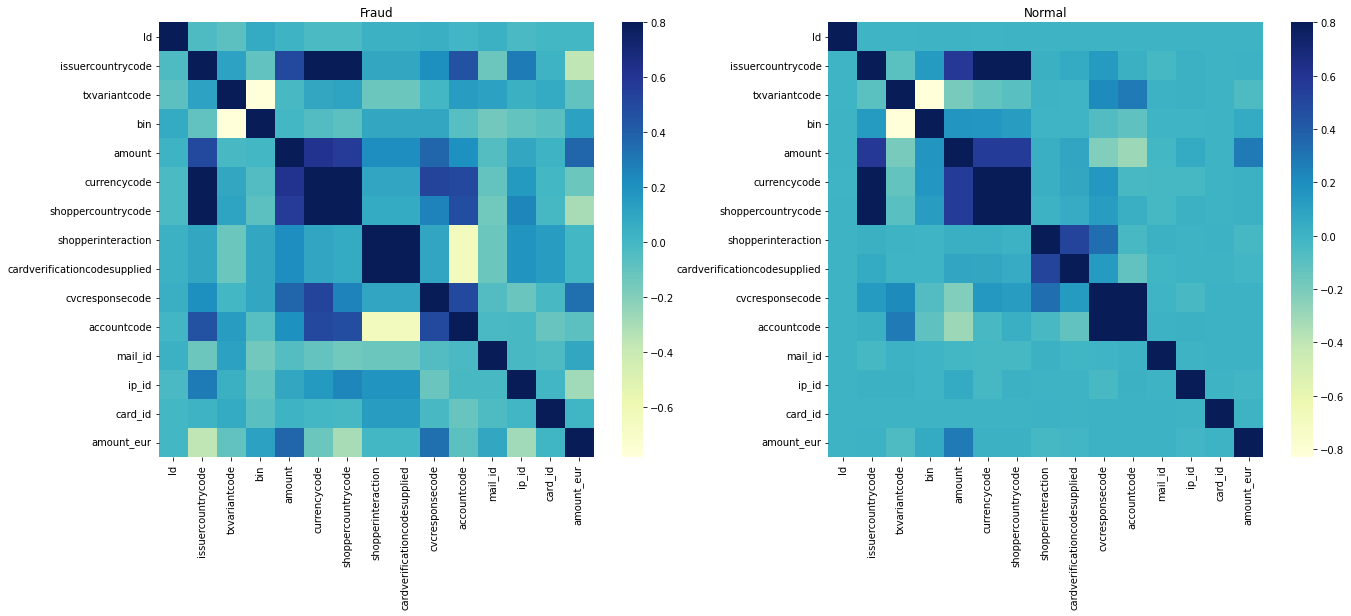

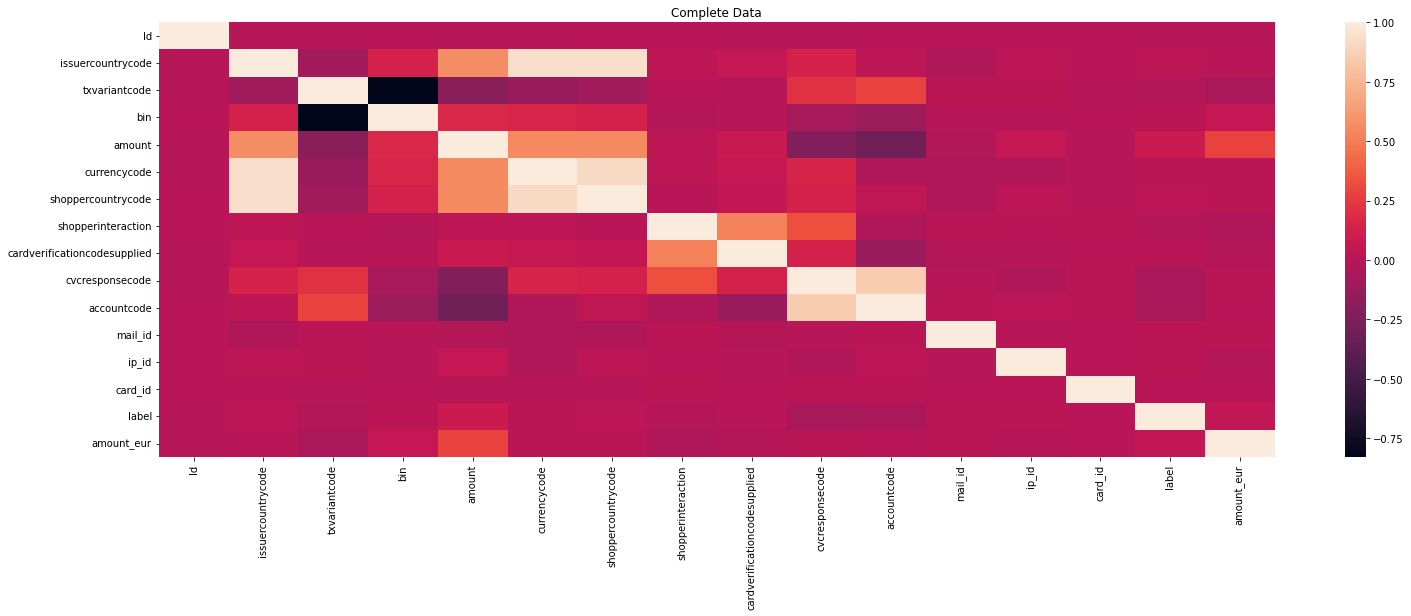

In [12]:
#correlation matrices
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))

sns.heatmap(df1.query('label==1').drop('label', axis='columns').corr(), vmax=.8, square=True, ax=ax1, cmap='YlGnBu')
ax1.set_title('Fraud')

sns.heatmap(df1.query('label==0').drop('label', axis='columns').corr(), vmax=.8, square=True, ax=ax2, cmap='YlGnBu')
ax2.set_title('Normal')

plt.show()

f, (ax1) = plt.subplots(1, figsize=(25, 8))
sns.heatmap(df1.corr())
ax1.set_title('Complete Data')

plt.show()

# Applying machine learning

## SVM

In [13]:
Y = df1['label']

svm_classifier = svm.SVC()
svm_classifier.fit(X, Y)



SVC()

In [17]:
test_df = pd.read_csv('data/test_data.csv')

X_test = process_data(test_df)

Y_predictions = svm_classifier.predict(X_test)

print(f"Accuracy: {accuracy_score(X_test, Y_predictions) * 100}")

ValueError: Classification metrics can't handle a mix of unknown and binary targets